# Chapter 5 - Actor-Critic Models

## 2. 분산 훈련

### Listing 5.1 간단한 다중 프로세싱 예제

In [1]:
import multiprocessing as mp
import numpy as np

In [2]:
def square(x):  # 이 함수는 하나의 배열을 받아서 배열의 각 성분을 제곱한다.
    return np.square(x)  # 일련의 수들로 배열을 채운다.

In [3]:
x = np.arange(64)
print(x)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


In [4]:
mp.cpu_count()

8

In [5]:
pool = mp.Pool(8)  # CPU 개수와 같은 프로세스 여덟 개짜리 다중 프로세싱 풀을 만든다.
squared = pool.map(square, [x[8*i:8*i+8] for i in range(8)])  # 풀의 map 메서드를 이용해서 square 함수를 목록의 각 배열에 적용하고 각 결과를 하나의 목록으로 취합한다.
squared

[array([ 0,  1,  4,  9, 16, 25, 36, 49]),
 array([ 64,  81, 100, 121, 144, 169, 196, 225]),
 array([256, 289, 324, 361, 400, 441, 484, 529]),
 array([576, 625, 676, 729, 784, 841, 900, 961]),
 array([1024, 1089, 1156, 1225, 1296, 1369, 1444, 1521]),
 array([1600, 1681, 1764, 1849, 1936, 2025, 2116, 2209]),
 array([2304, 2401, 2500, 2601, 2704, 2809, 2916, 3025]),
 array([3136, 3249, 3364, 3481, 3600, 3721, 3844, 3969])]

### Listing 5.2 개별 프로세스를 명시적으로 시작하는 예

In [6]:
def square(i, x, queue):
    print('In process {}'.format(i,))
    queue.put(np.square(x))

In [7]:
processes = []  # 각 프로세스의 참조를 담을 목록이다.
queue = mp.Queue()  # 프로세스들이 공유할 다중 프로세싱 대기열을 만든다.
x = np.arange(64)  # 제곱할 수들을 목록에 채워 넣는다.
for i in range(8):  # 여덟 개의 프로세스에서 각각 square 함수를 실행한다. 각 프로레스는 서로 다른 데이터 조각을 처리한다.
    start_index = 8 * i
    proc = mp.Process(target=square, args=(i, x[start_index:start_index+8], queue))
    proc.start()
    processes.append(proc)
    
for proc in processes:  # 모든 프로세스가 완료되길 기다린다.
    proc.join()
    
for proc in processes:  # 모든 프로세스를 종료한다.
    proc.terminate()
    
results = []
while not queue.empty():  # 다중 프로세싱 대기열으 ㅣ항목들을 최종 결과 목록에 넣는다.
    results.append(queue.get())
    
results

In process 0
In process 1
In process 2
In process 3
In process 4In process 5

In process 6
In process 7


[array([ 0,  1,  4,  9, 16, 25, 36, 49]),
 array([ 64,  81, 100, 121, 144, 169, 196, 225]),
 array([256, 289, 324, 361, 400, 441, 484, 529]),
 array([576, 625, 676, 729, 784, 841, 900, 961]),
 array([1024, 1089, 1156, 1225, 1296, 1369, 1444, 1521]),
 array([1600, 1681, 1764, 1849, 1936, 2025, 2116, 2209]),
 array([2304, 2401, 2500, 2601, 2704, 2809, 2916, 3025]),
 array([3136, 3249, 3364, 3481, 3600, 3721, 3844, 3969])]

### Listing 5.3 온라인 이익 행위자-비평자의 의사코드

```python
gamma = 0.9
for i in epochs:  # 일정 횟수로 훈련을 반복한다.
    state = environment.get_state()  # 환경의 현재 상태를 얻는다.
    value = critic(state)  # 상태의 가치를 예측한다.
    policy = actor(state)  # 상태의 동작들에 관한 확률분포를 예측한다.
    action = policy.sample()  # 정책의 동작 확률분포에 따라 동작 하나를 추출한다.
    next_state, reward = environment.take_action(action)
    value_next = critic(next_state)  # 다음 상티의 가치를 예측한다.
    advantage = reward + (gamma * value_next - value)  # 보상에 다음 상태 가치와 현재 상태 가치의 차이를 더한 값을 이익으로 둔다.
    loss = -1 * policy.logprob(action) * advantage  # 계산된 이익에 기초해서 동작을 강화한다.
    minimize(loss)
```

### Listing 5.4 CartPole 행위자-비판자 모형

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.multiprocessing as mp  # PyTorch 는 파이썬의 내장 multiprocessing 라이브러리를 감싼 모듈을 제공한다. API 는 동일하다.
import numpy as np
import gym
import warnings
warnings.filterwarnings('ignore')

/home/heerak_son/workspace/RL/venv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/heerak_son/workspace/RL/venv/lib/python3.6/site-packages/gym/core.py:26: UserWarning: WARN: Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+
  "Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+"


In [9]:
class ActorCritic(nn.Module):  # 행위자와 비평자를 하나의 신경망으로 결합한 모형을 정의한다.
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.l1 = nn.Linear(4, 25)
        self.l2 = nn.Linear(25, 50)
        self.actor_lin1 = nn.Linear(50, 2)
        self.l3 = nn.Linear(50, 25)
        self.critic_lin1 = nn.Linear(25, 1)
        
    def forward(self, x):
        x = F.normalize(x, dim=0)
        y = F.relu(self.l1(x))
        y = F.relu(self.l2(y))
        actor = F.log_softmax(self.actor_lin1(y), dim=0)  # 행위자는 두 가지 동작의 로그 확률들을 출력한다.
        c = F.relu(self.l3(y.detach()))
        critic = torch.tanh(self.critic_lin1(c))  # 비평자는 -1 에서 +1 사이의 수치 하나를 출려갛ㄴ다.
        return actor, critic  # 행위자의 출력과 비평자의 출력을 하나의 튜플에 담아서 돌려준다.

### Listing 5.6 주 훈련 루프

In [10]:
def worker(t, worker_model, counter, params):
    worker_env = gym.make('CartPole-v1')
    worker_env.reset()
    worker_opt = optim.Adam(lr=1e-4, params=worker_model.parameters())  # 각 프로세스는 자신만의 격리된 환경에서 에피소드를 실행하고 모형을 훈련하지만, 하나의 모형을 모든 프로세스가 공유한다.
    worker_opt.zero_grad()
    for i in range(params['epochs']):
        worker_opt.zero_grad()
        values, logprobs, rewards = run_episode(worker_env, worker_model)  # run_episode 함수는 에피소드를 실행해서 데이터를 수집한다.
        actor_loss, critic_loss, eplen = update_params(worker_opt, values, logprobs, rewards)  # run_episode 로 수집한 데이터로 매개변수들을 한 단계 갱신한다.
        counter.value = counter.value + 1  # counter 는 모든 프로세스가 공유하는 전역 카운터이다.

### Listing 5.7 에피소드 실행

In [11]:
def run_episode(worker_env, worker_model):
    state = torch.from_numpy(worker_env.env.state).float()  # NumPy 배열 형태의 환경 상태를 PyTorch 텐서로 변환한다.
    values, logprobs, rewards = [], [], []  # 계산된 상태 가치(비평자), 로그 확률(행위자), 보상을 수집할 목록들을 초기화한다.
    done = False
    j = 0
    while done == False:  # 에피소드가 끝날 때까지 플레이한다.
        j += 1
        policy, value = worker_model(state)  # 상태 가치와 동작들에 과한 로그 확률들을 계산한다.
        values.append(value)
        logits = policy.view(-1)
        action_dist = torch.distributions.Categorical(logits=logits)
        action = action_dist.sample()  # 행위자의 동작 로그 확률들을 이용해서 범주형 확률분포를 만들고 동작을 추출한다.
        logprob_ = policy.view(-1)[action]
        logprobs.append(logprob_)
        state_, _, done, info = worker_env.step(action.detach().numpy())
        state = torch.from_numpy(state_).float()
        if done:  # 이 동작에 의해 에피소드가 끝났다면 보상을 -10 으로 설정하고 환경을 초기화한다.
            reward = -10  
            worker_env.reset()
        else:
            reward = 1.0
        rewards.append(reward)
    return values, logprobs, rewards

### Listing 5.8 손실 계산 및 최소화

In [12]:
def update_params(worker_opt, values, logprobs, rewards, clc=0.1, gamma=0.95):
    # 주어진 배열 rewards, logprobs, values 를 뒤집고(성분들을 역순으로 정렬) .view(-1) 을 호출해서 평평하게 만든다(호출하는 쪽에서 1차원 배열이 아닌 텐서를 넘겨주었을 수도 있으므로).
    rewards = torch.Tensor(rewards).flip(dims=(0,)).view(-1)  # [1, 1, 1, 1, 1, -10] -> [-10, 1, 1, 1, 1, 1]
    logprobs = torch.stack(logprobs).flip(dims=(0,)).view(-1)
    values = torch.stack(values).flip(dims=(0,)).view(-1)
    
    Returns = []
    ret_ = torch.Tensor([0])
    for r in range(rewards.shape[0]):  # 보상들을 차례로(원래 수집한 것과는 역순) 훑으면서 각 보상으로 수익을 계산해서 returns 배열에 넣는다.
        ret_ = rewards[r] + gamma * ret_
        Returns.append(ret_)
    Returns = torch.stack(Returns).view(-1)
    Returns = F.normalize(Returns, dim=0)
    actor_loss = -1 * logprobs * (Returns - values.detach())  # 행위자의 손실을 계산한다. 비평자의 손실이 역전파되지 않도록 values 노드를 계산 그래프에서 떼어낸다는 점 도 주목하기 바란다.
    critic_loss = torch.pow(values - Returns, 2)  # 비평자의 손실을 계산한다. 이 손실은 이 모형이 보상을 좀 더 잘 예측하게 만드는 효과를 낸다.
    loss = actor_loss.sum() + clc * critic_loss.sum()  # 행위자의 손실과 비평자의 손실을 더해서 총 손실을 구하되, 비평자의 손실을 적절한 비율로 감소(할인)한다.
    loss.backward()
    worker_opt.step()
    return actor_loss, critic_loss, len(rewards)

### Listing 5.5 훈련의 분산

In [13]:
MasterNode = ActorCritic()  # 프로세스들이 공유할 전역 행위자-비평자 모형을 생성한다.
MasterNode.share_memory()  # share_memory 메서드는 프로세스들이 모형의 매개변수들을 각자 복사하는 것이 아니라 그대로 공유하게 만든다.
processes = []  # 프로레스 인스턴스들을 담을 목록을 초기화한다.
params = {
    'epochs': 1000,
    'n_workers': 7,
}
counter = mp.Value('i', 0)  # multiprocessing 의 내장 공유 객체를 하나의 전역 공유 카운터로 사용한다. 'i' 는 이 공유 객체의 데이터 형식이 정수(integer)라는 뜻이다.

for i in range(params['n_workers']):
    p = mp.Process(target=worker, args=(i, MasterNode, counter, params))  # 새 프로세스를 띄워서 worker 함수를 실행한다.
    p.start()
    processes.append(p)
    
for p in processes:  # 모든 프로세스가 작업을 마치길 기다린다.
    p.join()
for p in processes:  # 모든 프로세스를 종료한다.
    p.terminate()
    
print(counter.value, processes[1].exitcode)

6995 0


### Test the trained agent

In [16]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [24]:
env = gym.make('CartPole-v1')
env.reset()

for i in range(100):
    state_ = np.array(env.env.state)
    state = torch.from_numpy(state_).float()
    logits, value = MasterNode(state)
    action_dist = torch.distributions.Categorical(logits=logits)
    action = action_dist.sample()
    state2, reward, done, info = env.step(action.detach().numpy())
    if done:
        print('Lost')
        env.reset()
    state_ = np.array(env.env.state)
    state = torch.from_numpy(state_).float()
    env.render()

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0


In [21]:
import matplotlib.pyplot as plt

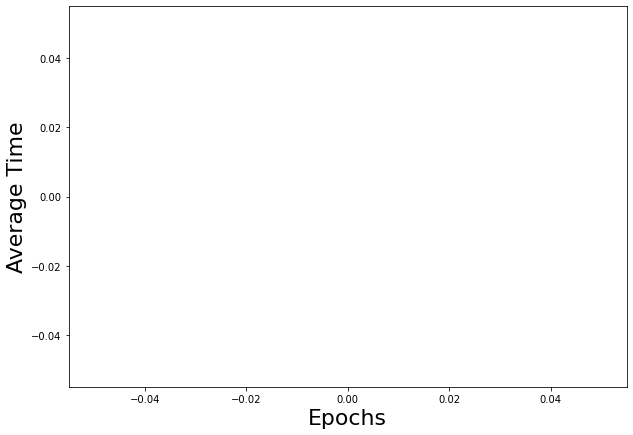

In [22]:
plt.figure(figsize=(10, 7))
plt.xlabel("Epochs", fontsize=22)
plt.ylabel('Average Time', fontsize=22)
plt.plot(result)
plt.show()